<a href="https://colab.research.google.com/github/DhivyaaSP/Deep-Learning/blob/main/CNN_EmotionDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import time

# Ensure TensorFlow uses the GPU, if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to only use the first GPU and enable memory growth
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [20]:
num_classes = 7   # angry, disgust, fear, happy, neutral, sad, and surprise

In [21]:
trainingset = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/fer2013_publictest_onehot.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

In [22]:
n_inputs = 2304
n_classes = 7
img_dim = 48

x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

x_training = x_training.reshape(x_training.shape[0], 48, 48)
x_training = np.expand_dims(x_training, axis=3)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
x_testing = np.expand_dims(x_testing, axis=3)

# Assuming y_training and y_testing are one-hot encoded
y_training_int = np.argmax(y_training, axis=1)
y_testing_int = np.argmax(y_testing, axis=1)

unique, counts = np.unique(y_training_int, return_counts=True)
print("Training set:")
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples")

unique, counts = np.unique(y_testing_int, return_counts=True)
print("\nTesting set:")
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples")

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator to your data
train_datagen.fit(x_training)

Training set:
Class 0: 3995 samples
Class 1: 436 samples
Class 2: 4097 samples
Class 3: 7215 samples
Class 4: 4830 samples
Class 5: 3171 samples
Class 6: 4965 samples

Testing set:
Class 0: 467 samples
Class 1: 56 samples
Class 2: 496 samples
Class 3: 895 samples
Class 4: 653 samples
Class 5: 415 samples
Class 6: 607 samples


In [23]:
# 64x64 portray image
input_image = Input(shape=(48, 48, 1), name='Input')

# First block of conv + maxpool + dropout
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_1')(input_image)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu', name='conv1_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.25, name='conv_dropout1')(x)

# Prepare skip connection with Conv2D for matching dimensions
skip_connection1 = Conv2D(filters=128, kernel_size=(3, 3), padding='valid', name='SkipConnection_1')(x)

# Second block
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_1')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_2')(x)
x = Add()([x, skip_connection1])
x = Conv2D(filters=218, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_3')(x)
x = Conv2D(filters=218, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_4')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = Dropout(rate=0.25, name='conv_dropout2')(x)

# Third block (4 Conv2D, 1 MaxPooling2D, 1 Dropout)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_1')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='valid', activation='relu', name='conv3_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
x = Dropout(rate=0.25, name='conv_dropout3')(x)

x = Flatten(name='flatten')(x)

# FC layers + dropout
x = Dense(units=1024, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5, name='fc_dropout1')(x)

x = Dense(units=512, activation='relu', name='fc2')(x)
x = Dropout(rate=0.5, name='fc_dropout2')(x)

output_label = Dense(units=num_classes, activation='softmax', name='fc3_7ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='emo_cnn')

# Print model summary to verify the architecture
model.summary()

Model: "emo_cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv1_1 (Conv2D)            (None, 48, 48, 64)           640       ['Input[0][0]']               
                                                                                                  
 conv1_2 (Conv2D)            (None, 46, 46, 64)           36928     ['conv1_1[0][0]']             
                                                                                                  
 pool1 (MaxPooling2D)        (None, 23, 23, 64)           0         ['conv1_2[0][0]']             
                                                                                            

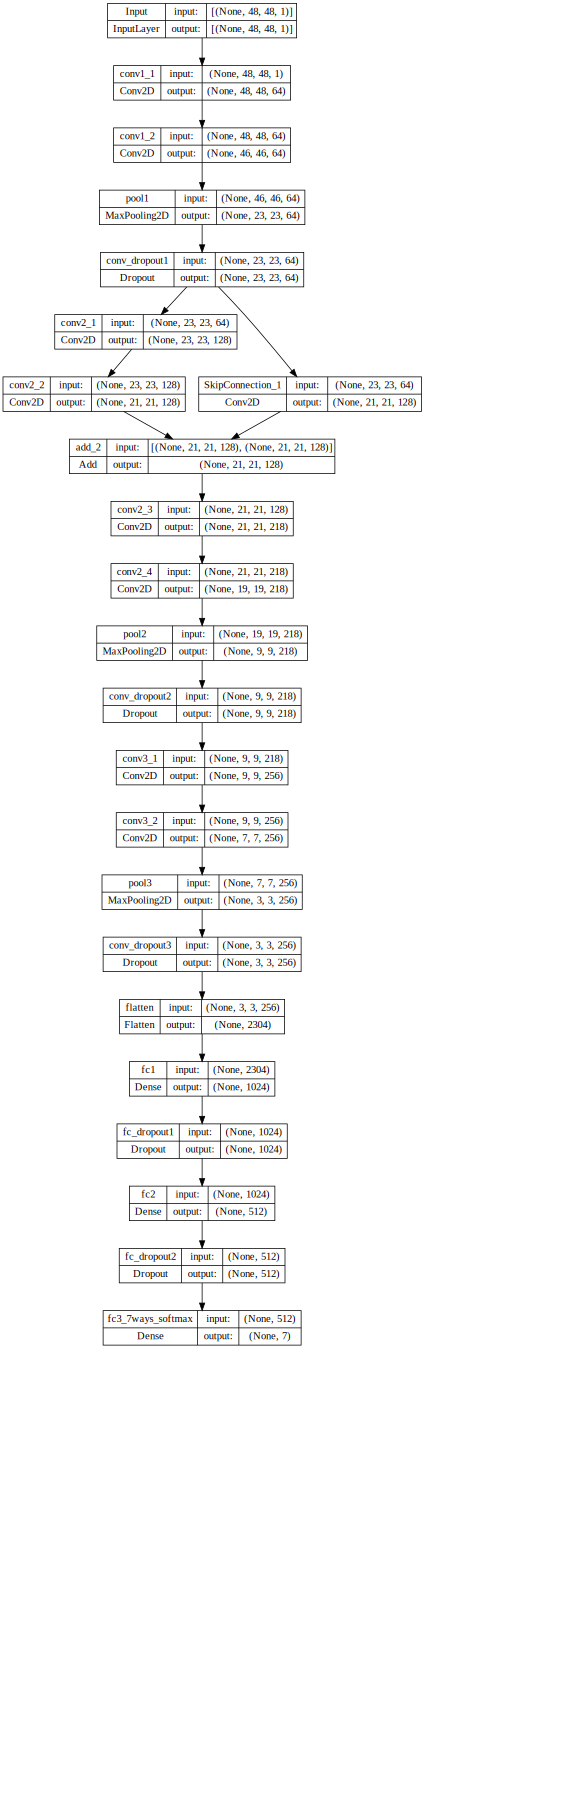

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/model.png', show_shapes=True)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [25]:
loss = 'categorical_crossentropy'
# Set hyperparameters
batch_size = 128
epochs = 75
learning_rate = 0.0005  # Define learning rate as a variable for easy adjustment

# Configure batch size and retrieve a batch of images
train_generator = train_datagen.flow(
    x_training,
    y_training,
    batch_size=batch_size
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

# Compile the model with the learning rate
model.compile(loss=loss, optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Record the starting time
starting_time = time.time()

# Train the model with the training data generator and validation data
history = model.fit(
    train_generator,
    steps_per_epoch=x_training.shape[0] // batch_size,
    validation_data=(x_testing, y_testing),
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]  # Add callbacks here
)

# Calculate and print the training time
training_time_minutes = (time.time() - starting_time) / 60
print('> training time is %.4f minutes' % training_time_minutes)

Epoch 1/75
224/224 [==============================] - 29s 115ms/step - loss: 1.9896 - accuracy: 0.2384 - val_loss: 1.8194 - val_accuracy: 0.2494 - lr: 5.0000e-04
Epoch 2/75
224/224 [==============================] - 26s 118ms/step - loss: 1.7966 - accuracy: 0.2588 - val_loss: 1.7048 - val_accuracy: 0.3070 - lr: 5.0000e-04
Epoch 3/75
224/224 [==============================] - 26s 115ms/step - loss: 1.7365 - accuracy: 0.2891 - val_loss: 1.6604 - val_accuracy: 0.3341 - lr: 5.0000e-04
Epoch 4/75
224/224 [==============================] - 26s 114ms/step - loss: 1.6835 - accuracy: 0.3223 - val_loss: 1.5230 - val_accuracy: 0.4157 - lr: 5.0000e-04
Epoch 5/75
224/224 [==============================] - 26s 114ms/step - loss: 1.5668 - accuracy: 0.3820 - val_loss: 1.3824 - val_accuracy: 0.4620 - lr: 5.0000e-04
Epoch 6/75
224/224 [==============================] - 26s 114ms/step - loss: 1.4816 - accuracy: 0.4221 - val_loss: 1.3185 - val_accuracy: 0.4985 - lr: 5.0000e-04
Epoch 7/75
224/224 [========

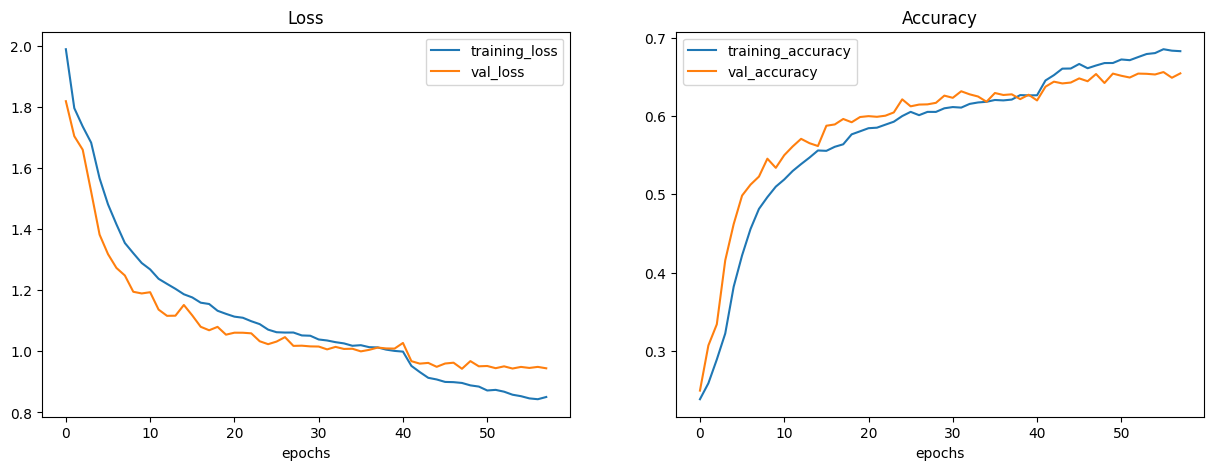

In [26]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

plot_curves(history)

In [27]:
score = model.evaluate(x_testing, y_testing)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

113/113 [==============================] - 1s 9ms/step - loss: 0.9430 - accuracy: 0.6537
Test loss: 0.9430233240127563
Test accuracy: 0.6536639928817749


In [28]:
def get_emotion(ohv):
    indx = np.argmax(ohv)

    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

1/1 [==============================] - 0s 486ms/step


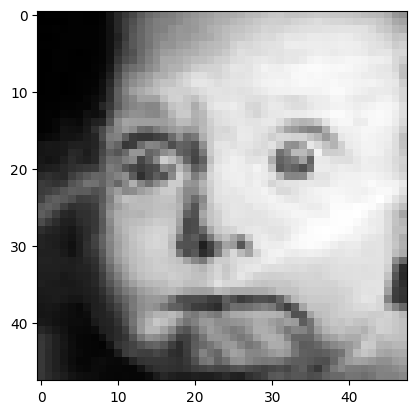

> testing image index: 2049
> true emotion: fear
> predicted emotion: fear


In [29]:
# 2163
img_indx = np.uint32(np.random.rand()*(testingset.shape[0] - 1))
sample = x_testing[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))

113/113 [==============================] - 1s 7ms/step


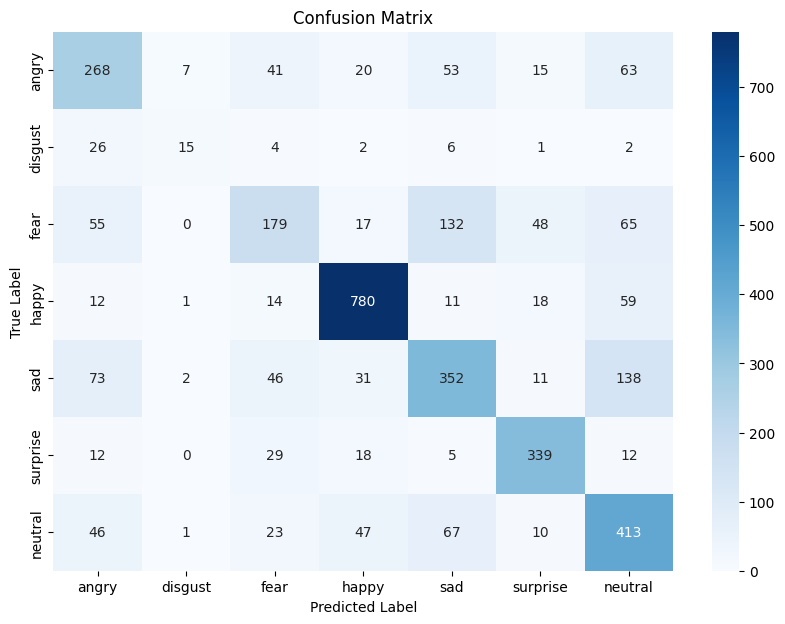

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Make predictions for the entire test set
predictions = model.predict(x_testing)

# Convert predictions and true labels from one-hot vectors to integers
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_testing, axis=1)
cm = confusion_matrix(y_true, y_pred)
# Define class names as a list
class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()